# Cubed sphere grid explanation with Weimer potential

Create a figure explaining the cubed sphere grid object (Figure 1 in paper).

We will use a [Weimer (2005)](https://doi.org/10.1029/2004JA010884) model potential $\Phi$ in the northern hemisphere. Using the differentiation matrices $\mathbb D_{\mathbf{e}\cdot\nabla}$, $\mathbb D_{\mathbf{n}\cdot\nabla}$ from the cubed sphere grid object, we can differentiate this scalar field and get the electric field through the relation $\mathbf{E} = -\nabla\Phi$. When ignoring inductive effects this equation relates the electric fieldand the electrostatic potential. We can also get the divergence of the electric field $\mathbf{E}$ by using the $\mathbb D_{\nabla\cdot}$ matrix from the cubed sphere grid object. When applied to a vector field, $\mathbb D_{\nabla\cdot}$ produces the divergence of the vector field. 

Below we:
 1. Set up the cubed sphere projection and grid
 2. Read a Weimer model output file and define electrostatic potential on grid
 3. Get east, north electric field from the potential
 4. Get the divergence of the electric field and multiply by $\epsilon_0$ to get charge density
 5. Plot
 
Import relevant modules:

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import apexpy
from scipy.interpolate import griddata
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import lompe

Re = 6371.2e3    # Earth radius
eps0 = 8.854e-12 # Electric permittivity of free space 
stencil_size = 1 # Size of the stencil used for numerical differentiation

#### Set up cubed sphere grid

The cube face is centered at the north pole (0$^{\circ}$ longtude and 90$^{\circ}$ latitude) and oriented along the meridian (orientation set to zero implies axis in the east-west direction). the projection is used to set up an equal area grid in cubed sphere coordinates. Here, the grid covers a 20 000 km $\times$ 20 000 km area.

In [2]:
Lres, Wres = 100e3, 100e3  # m
projection = lompe.cs.CSprojection(position = (0, 90), orientation = 0)        # east, west oriented xi-axis
grid = lompe.cs.CSgrid(projection, 20000e3, 20000e3, Lres, Wres, R = Re+110e3) # set to ionospheric altitude
SKIP = 20 # how many grid points to skip when smoothing 

#### Electrostatic potential

Next, we read a file containing a [Weimer (2005)](https://doi.org/10.1029/2004JA010884) model electric potential and interpolate the potential $\Phi$ on the grid:

In [3]:
# read potential file:
weimer = pd.read_table('./datasets/weimer.txt', sep = ' ', skipinitialspace = True, comment = '#', names = ['mlat', 'mlt', 'R_E', 'phi'])
weimer = weimer[weimer.mlat > 0] # remove southern hemisphere

# get lat, lon coordinates, convert to SI-units
latxx = weimer.mlat.values.reshape((181, 61))
lonxx = weimer.mlt .values.reshape((181, 61)) * 15  # mlt to lon
V     = weimer.phi .values.reshape((181, 61)) * 1e3 # kV to V

# interpolate potential to cubedsphere grid:
xi, eta = grid.projection.geo2cube(lonxx, latxx)
V       = griddata((xi.flatten(), eta.flatten()), V.flatten(), (grid.xi.flatten(), grid.eta.flatten()), fill_value = 0, method = 'cubic').reshape(grid.shape)

#### Horizontal electric field

The grid object contains the matrices that produces derivative in eastward and northward direction of a scalar field defined on the grid: $\mathbb D_{\mathbf{e}\cdot\nabla}$, $\mathbb D_{\mathbf{n}\cdot\nabla}$. We use the matrices to differentiate $\Phi$ to get electric field components:
\begin{equation*}
    \mathbf{E}_{\mathbf{e}} = -\mathbb D_{\mathbf{e}\cdot\nabla}\cdot\Phi
\end{equation*}
\begin{equation*}
    \mathbf{E}_{\mathbf{n}} = -\mathbb D_{\mathbf{n}\cdot\nabla}\cdot\Phi
\end{equation*}
    
The stencil_size scales the interval for the final difference calculation of the derivatives. A larger stencil size will usually yield more accurate derivatives, but is more sensitive to noise. We have stencil_size = 1, and the derivatives are calculated with a 3-point stencil.

We choose to make the differation matrices sparse (this reduces the size of the matrix making computations more effective).

In [4]:
# use cubedsphere differentiation matrices to get electric field:
De, Dn = grid.get_Le_Ln(S = stencil_size, return_sparse = True)
E_e = -De.dot(V.flatten()).reshape(grid.shape)
E_n = -Dn.dot(V.flatten()).reshape(grid.shape)

#### Divergence of electric field

We can also calculate the divergence of the electric field:
\begin{equation*}
    \nabla\cdot\mathbf{E} = \mathbb D_{\nabla\cdot}\begin{pmatrix}\mathbf{E}_{\mathbf{e}}\\\mathbf{E}_{\mathbf{n}}\end{pmatrix}
\end{equation*}

The grid object contains the matrix that produces the divergence of a vector field (here: $\mathbf{E}$) on the grid: $\mathbb D_{\nabla\cdot}$. $\mathbb D_{\nabla\cdot}$ is a $N\times 2N$ matrix that operates on $\mathbf{E}$ that is a $2N$ column vector.

The divergence of the electric field is related to the charge density, $\rho_c$, through Gauss' law:
\begin{equation*}
    \rho_c = \epsilon_0\nabla\cdot\mathbf{E}
\end{equation*}
where $\epsilon_0$ is the permittivity of free space (constant).

In [5]:
E_tot = np.hstack((E_e.flatten(), E_n.flatten()))

# use cubedsphere divergence matrix to get div(E)
Ddiv = grid.divergence(S = stencil_size, return_sparse = True)
divE = Ddiv.dot(E_tot).reshape(grid.shape)

# we save the div(E) matrix for a later application
divE_save = pd.DataFrame({'divE':divE.flatten()})
divE_save.to_hdf('./datasets/01divE.h5', key = 'df', mode = 'w')

# convert to charge density - Gauss' law
epsdivE = divE * eps0 

#### Plotting

To avoid plotting results of edge effects, we remove the lower magnetic latitudes before plotting:

In [6]:
E_e[grid.lat < 61] = np.nan
E_n[grid.lat < 61] = np.nan
epsdivE[grid.lat < 61] = np.nan

Make a helper function to get coastlines on grids defined in magnetic coordinates:

In [7]:
def get_mag_coastlines(proj, apex, **kwargs):
    """ get coastlines in xi, eta for a grid defined in magnetic longitude and latitude """
    import cartopy.io.shapereader as shpreader
    coastlinekwargs = {'resolution':'50m', 'category':'physical', 'name':'coastline'}
    coastlinekwargs.update(kwargs)
    shpfilename = shpreader.natural_earth(**coastlinekwargs)
    reader = shpreader.Reader(shpfilename)
    coastlines = reader.records()
    multilinestrings = []
    for coastline in coastlines:
        if coastline.geometry.geom_type == 'MultiLineString':
            multilinestrings.append(coastline.geometry)
            continue
        lon, lat = np.array(coastline.geometry.coords[:]).T
        mlat, mlon = a.geo2apex(lat, lon, apex.refh) # geographic -> magnetic
        yield proj.geo2cube(mlon, mlat)

    for mls in multilinestrings:
        for ls in mls:
            lon, lat = np.array(ls.coords[:]).T
            mlat, mlon = a.geo2apex(lat, lon, height) # geographic -> magnetic
            yield proj.geo2cube(mlon, mlat)

Set up figure and panels

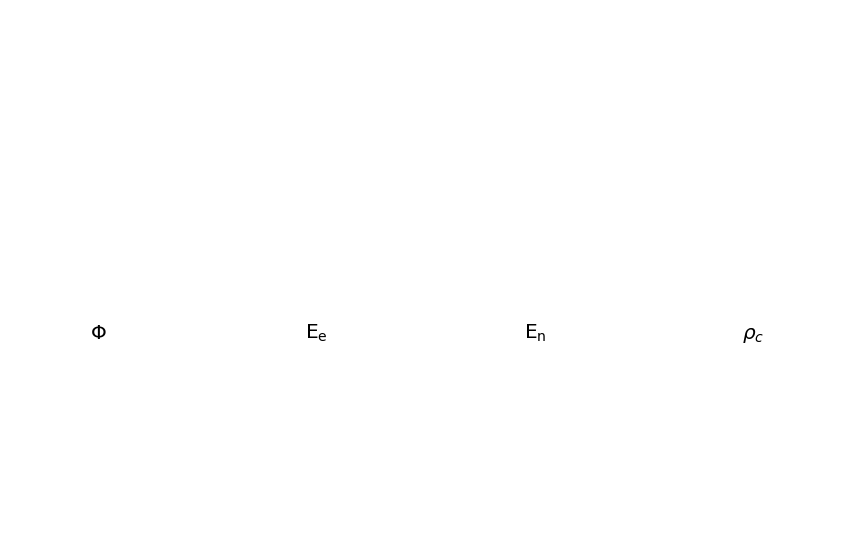

In [22]:
# Start by setting up figure and subplots:
fig = plt.figure(figsize = (15,10))
spec = fig.add_gridspec(20, 4)
axs = {}

# upper row
axs['onsphere' ] = fig.add_subplot(spec[0:13, 0:2])
axs['grid'     ] = fig.add_subplot(spec[0:13, 2:4])

# lower row
axs['potential'] = fig.add_subplot(spec[13:, 0])
axs['E_e'      ] = fig.add_subplot(spec[13:, 1])
axs['E_n'      ] = fig.add_subplot(spec[13:, 2])
axs['Ediv'     ] = fig.add_subplot(spec[13:, -1])

# title some axes
axs['potential'].set_title(r'$\Phi$',                    fontsize = 20, y = 1.1)
axs['E_e'      ].set_title(r'$\mathrm{E}_{\mathrm{e}}$', fontsize = 20, y = 1.1)
axs['E_n'      ].set_title(r'$\mathrm{E}_{\mathrm{n}}$', fontsize = 20, y = 1.1)
axs['Ediv'     ].set_title(r'$\rho_c$',                  fontsize = 20, y = 1.1)

# remove borders from axes
for key in axs.keys():
    axs[key].set_axis_off()

##### Upper row of panels

To illustrate how the area of the grid cells change with distance from the center of the cube face, we make a simple illustration of a cube face intersecting a sphere. We also include a panel showing the grid on a map. (The grid cells are equal area in the cube coordinate system.)

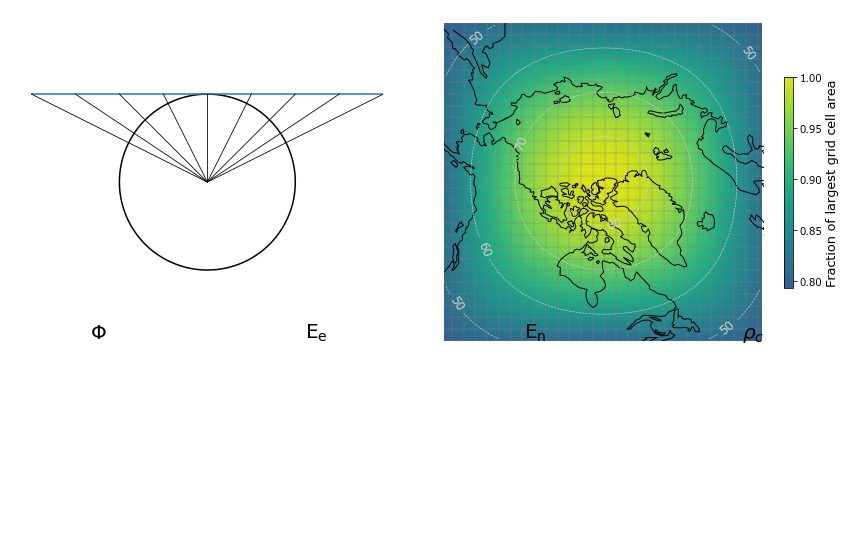

In [23]:
# A) example of cube face intersecting sphere 
# function for circle
xs = np.linspace(-4,4,1000)
ys = np.linspace(-4,4,1000)
a, b = np.meshgrid(xs, ys)
C = a ** 2 + b ** 2 - 16     # funtion for a circle
c=axs['onsphere'].contour(a, b, C, levels=[0], colors='black')
axs['onsphere'].set_aspect('equal')

# cross section of grid that is intersecting the sphere
axs['onsphere'].plot([-8,8],[4,4])

# lines from center of sphere to grid
for i in range(-8,9,2):
    axs['onsphere'].plot([0,i],[0,4], color='black', linewidth=.8)

# latitudes
#for deg in [20,40,60,80]:
#    x1, y1 = 4*np.cos(np.deg2rad(deg)), 4*np.sin(np.deg2rad(deg))
#    x2, y2 = -x1, y1
#    axs['onsphere'].scatter([x1,x2], [y1,y2], c='black', s=5, marker='X')

axs['onsphere'].set_xlim(-8,8)
axs['onsphere'].set_ylim(-8,8)

# B) cubed sphere grid with coastlines
axs['grid'].set_aspect('equal')

# add coastlines
a = apexpy.Apex(2005., refh=110) # for coord. conversion to get coastlines in magnetic
for cl in get_mag_coastlines(grid.projection, apex=a, resolution='110m'):
    axs['grid'].plot(cl[0], cl[1], color = 'black', linewidth=1)

# plot some of the grid cells
count = -1
for xi, eta in grid.get_grid_boundaries(geocentric = False):
    count += 1
    if count%3 != 0:
        continue
    axs['grid'].plot(xi, eta, color='grey', linewidth=.4, zorder=1)

xlim, ylim = (grid.xi_mesh[0, 0], grid.xi_mesh [-1, -1]+.01), (grid.eta_mesh [0, 0], grid.eta_mesh[-1, -1])
axs['grid'].set_ylim(ylim)
axs['grid'].set_xlim(xlim)

# shade under grid region for area
cmapIn = plt.get_cmap('viridis')
new_cmap = LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(n=cmapIn.name, a=.3, b=.95),
                                             cmapIn(np.linspace(.3, .95, 100)))
ticks = np.linspace(.8, 1, 5)
areas =axs['grid'].pcolormesh(grid.xi, grid.eta, grid.A/grid.A.max(),cmap=new_cmap, zorder=0)

# color bar
cbar1 = fig.colorbar(areas, ax=axs['grid'], ticks=ticks, orientation='vertical', shrink=.6, aspect=25)
cbar1.ax.tick_params(labelsize=10)
cbar1.ax.set_ylabel('Fraction of largest grid cell area', fontsize=13)

# add latitude contours
co = axs['grid'].contour(grid.xi, grid.eta, grid.lat, linestyles = '--', colors = 'lightgrey', 
                                                linewidths = .6, levels = np.r_[-80:81:10], zorder=2)
axs['grid'].clabel(co, co.levels, inline = True, fontsize = 12)

#axs['grid'].scatter(, grid.eta)

fig

##### Lower row of panels

The electric potential, and the elecric field and charge density derived from it are plotted in the lower panels.

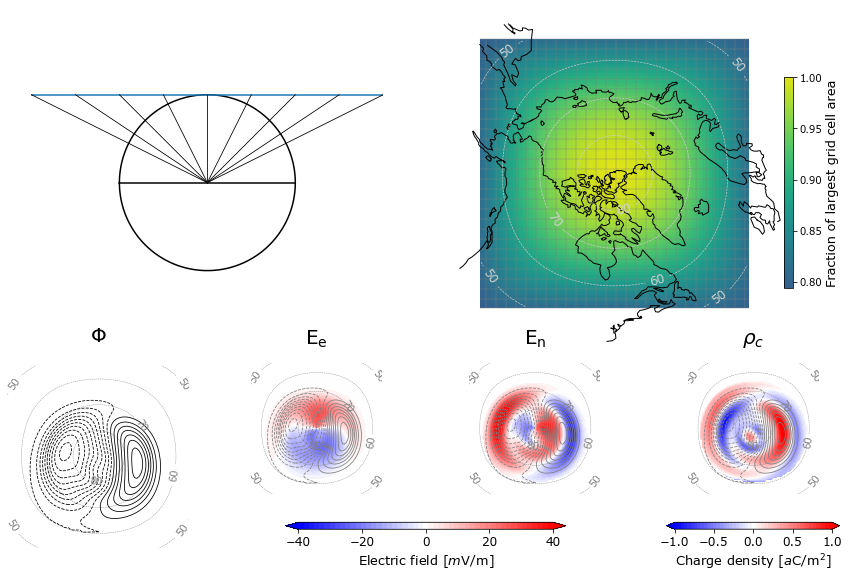

In [11]:
# Set up axes for phi, Ee, En, divE
for key in axs.keys():
    if key in ['grid','onsphere']: 
        continue
    if 'label' in key:
        continue
    axs[key].set_aspect('equal')
    
    # latitude contours
    c = axs[key].contour(grid.xi, grid.eta, grid.lat, linestyles = '--', colors = 'grey', 
                                                linewidths = .4, levels = np.r_[-80:81:10])
    axs[key].clabel(c, c.levels, inline = True, fontsize = 10)

# C) Potential
# f = Phi
axs['potential'].contour(grid.xi, grid.eta, V, colors = 'black', levels = np.r_[-101:101:4] * 1e3, linewidths = .8)

# add potential contours to plots D)-F)
axs['E_e' ].contour(grid.xi, grid.eta, V, colors = 'gray', levels = np.r_[-101:101:4] * 1e3, linewidths = .8)
axs['E_n' ].contour(grid.xi, grid.eta, V, colors = 'gray', levels = np.r_[-101:101:4] * 1e3, linewidths = .8)
axs['Ediv'].contour(grid.xi, grid.eta, V, colors = 'gray', levels = np.r_[-101:101:4] * 1e3, linewidths = .8)

# D) and E) - east, north E-field
# color scale for E-field components
Elevels = np.linspace(-40, 40, 50)
Elevel_ticks = np.linspace(-40, 40, 5)

# E_e = D_e * Phi
Eeastcont = axs['E_e'].contourf(grid.xi, grid.eta, E_e*1e3, cmap = plt.cm.bwr, levels = Elevels, extend='both')

# E_n = D_n * Phi
axs['E_n'].contourf(grid.xi, grid.eta, E_n*1e3, cmap = plt.cm.bwr, levels = Elevels, extend='both')

# color bar for E-field components
cbar2 = fig.colorbar(Eeastcont, ax=[axs['E_e'], axs['E_n']], ticks=Elevel_ticks, 
             orientation='horizontal', shrink=0.7, aspect=40)
cbar2.ax.tick_params(labelsize=12)
cbar2.ax.set_xlabel(r'Electric field [$m$V/m]', fontsize=13)
# F) charge density

# color scale for charge density (eps*divE)
divElevels = np.linspace(-1, 1, 50)
rho_ticks = np.linspace(-1, 1, 5) 

# divE = D_div * E, epsdivE = eps*divE
rho_c = axs['Ediv'].contourf(grid.xi, grid.eta, epsdivE*1e18, cmap = plt.cm.bwr, levels = divElevels, extend='both')

# color bar for charge density
cbar3 = fig.colorbar(rho_c, ax=axs['Ediv'], ticks=rho_ticks, orientation='horizontal', shrink=0.95, aspect=25)
cbar3.ax.tick_params(labelsize=12)
cbar3.ax.set_xlabel(r'Charge density [$a$C/m$^2$]', fontsize=13)

fig

Adjust figure and save

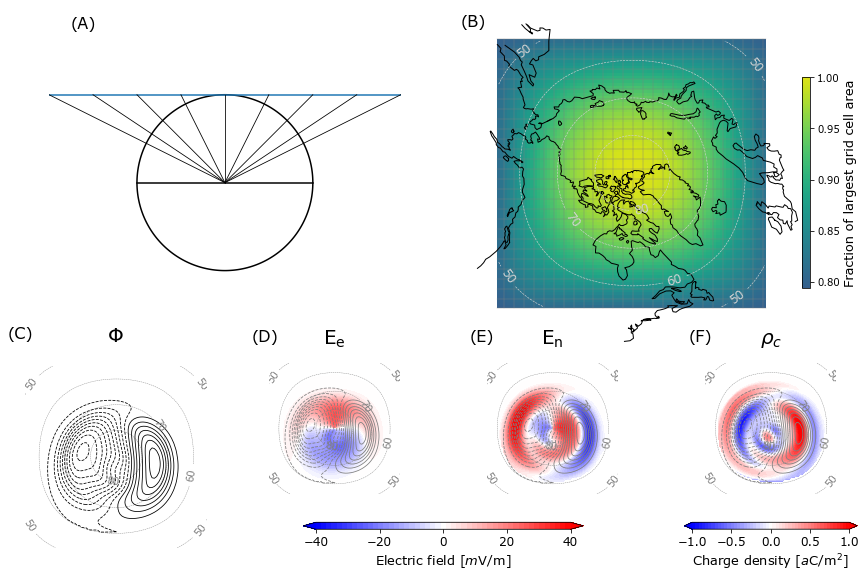

In [12]:
# add subfigure letters
axs['onsphere' ].text(-7,    7,    '(A)', fontsize=16)
axs['grid'     ].text(-0.8,  0.68, '(B)', fontsize=16)
axs['potential'].text(-0.74, 0.8,  '(C)', fontsize=16)
axs['E_e'      ].text(-0.78, 0.82, '(D)', fontsize=16)
axs['E_n'      ].text(-0.78, 0.82, '(E)', fontsize=16)
axs['Ediv'     ].text(-0.78, 0.82, '(F)', fontsize=16)

# save figure
fig.savefig('./output_figures/CSexample.pdf')
fig.savefig('./output_figures/CSexample.png')

fig

The parameters are plotted in cubed sphere $\xi, \eta$ coordinates. Note that the center of the grid is at the magnetic north pole.

- (A) is left open for an illustration.
    
- (B) shows the area of the grid cells as the color map. It shows that the size of the cubed-sphere grid cell (on the sphere) get smaller and smaller the further away from the center of the cube face we get. 
    
- (C) The Weimer potential.
    
- (D) The eastward electric field component derived from the Weimer potential through $\mathrm{E}_{\mathrm{e}}=-\mathbb D_{\mathrm{e}}\cdot\Phi$.
    
- (E) The northward electric field component derived from the Weimer potential through $\mathrm{E}_{\mathrm{n}}=-\mathbb D_{\mathrm{n}}\cdot\Phi$.

- (F) The charge density calculated from $\rho_c=\epsilon_0\mathbb D_{\nabla\cdot}\mathbf{E}$.